In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df_najwa = pd.read_csv('najwa.tab', delimiter='\t')

In [3]:
df_najwa.dtypes

position                int64
channelId              object
channelTitle           object
videoId                object
publishedAt            object
publishedAtSQL         object
videoTitle             object
videoDescription       object
videoCategoryId         int64
videoCategoryLabel     object
duration               object
durationSec             int64
dimension              object
definition             object
caption                  bool
thumbnail_maxres       object
licensedContent       float64
viewCount               int64
likeCount               int64
dislikeCount            int64
favoriteCount           int64
commentCount            int64
dtype: object

In [4]:
df_najwa.drop(['position','channelId','videoId','publishedAt','publishedAtSQL','videoDescription','videoCategoryId',
              'videoCategoryLabel','duration','durationSec','dimension','definition','caption','thumbnail_maxres',
               'licensedContent','likeCount','dislikeCount','favoriteCount','commentCount'], axis=1, inplace=True)

In [5]:
df_najwa.head()

,channelTitle,videoTitle,viewCount
0,Najwa Shihab,"Transaksi Rekonsiliasi: Oposisi Dapat Kursi, S...",117990
1,Najwa Shihab,Transaksi Rekonsiliasi: Parpol Lompat Pagar (P...,195197
2,Najwa Shihab,Transaksi Rekonsiliasi: Dulu Begini Sekarang B...,371174
3,Najwa Shihab,"Transaksi Rekonsiliasi: Rekonsiliasi, Bagi-Bag...",217537
4,Najwa Shihab,Transaksi Rekonsiliasi - Pengamat: Rekonsilias...,280581


In [6]:
df_najwa['TitleLength'] = df_najwa['videoTitle'].str.len()

In [7]:
title_length = 'TitleLength'

In [8]:
columns = [{'column_name': 'viewCount', 'column_text':'Views'},
           {'column_name': title_length, 'column_text':'Title length'}]

In [9]:
sns.set_style('whitegrid')
sns.set_palette('coolwarm')

Total viewCount: 416561880 times


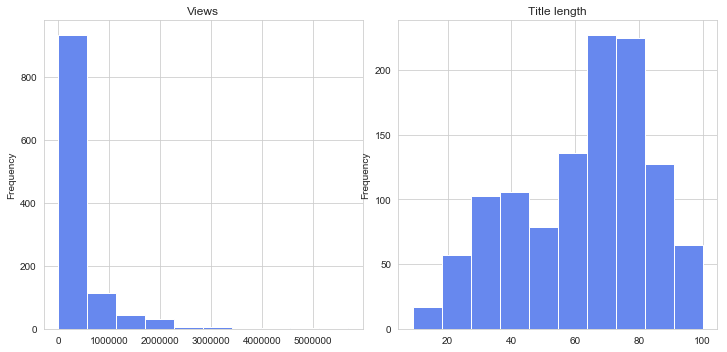

In [10]:
plt.figure(figsize=(20,5))
for el in columns:
    class_name = el['column_name']
    column = df_najwa[class_name]
    plt.subplot(1,4, columns.index(el)+1)
    plt.tight_layout()
    column.plot.hist(orientation='vertical', cumulative=False, title=el['column_text'])
    if class_name != title_length:
        print('Total {}: {} times'.format(class_name, column.sum()))

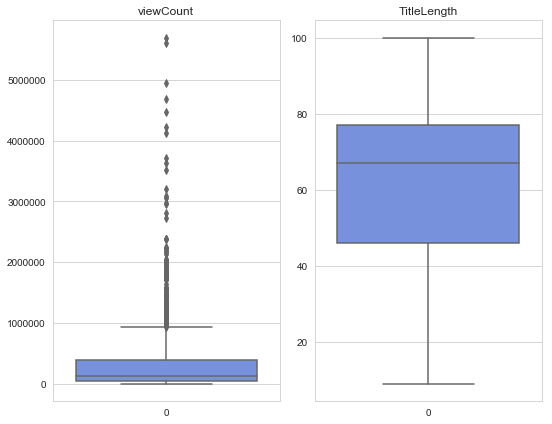

In [11]:
plt.figure(figsize=(15,6))
for el in columns:
    class_name = el['column_name']
    column = df_najwa[class_name]
    plt.subplot(1,4, columns.index(el) + 1)
    plt.tight_layout()
    plt.title(class_name)
    sns.boxplot(data=column)

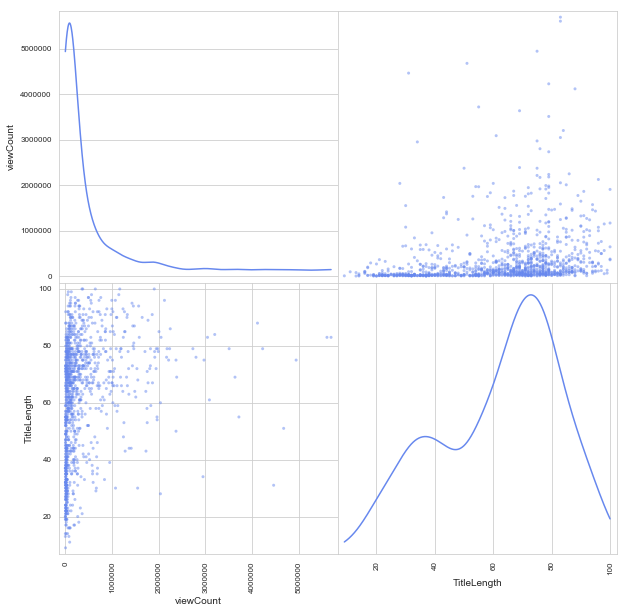

In [12]:
temp = pd.plotting.scatter_matrix(df_najwa[['viewCount','TitleLength']], diagonal='kde', figsize=(10,10))

In [13]:
PERCENTAGE = 25
def remove_outliers(df_najwa,column):
    Q1 = df_najwa[column].quantile(0.25)
    Q3 = df_najwa[column].quantile(0.75)
    IQR = Q3 - Q1
    non_outliers = (df_najwa[column] >= Q1 - 1.5*IQR) & (df_najwa[column] <= Q3 + 1.5*IQR)
    return df_najwa.loc[non_outliers]

def plot_top_length_performers(col_name, is_grouped):
    plt.figure(figsize=(20,5))
    for el in columns:
        class_name = el['column_name']
        column = df_najwa[class_name]
        if class_name != title_length:
            plt.subplot(1,3, columns.index(el) + 1)
            plt.tight_layout()
            
            title_top = remove_outliers(df_najwa, class_name)
            title_top = title_top.sort_values(by=[class_name], ascending=False).head(int(len(df_najwa)*(PERCENTAGE/100.00)))
            
            if(is_grouped):
                temp = title_top.groupby(pd.cut(title_top[col_name], bins=np.arange(0,140+10, step=10))).count()[class_name]
            else:
                temp = title_top.groupby(title_top[col_name]).count()[class_name]
            temp.plot.bar()
            
            plt.title('{} frequency'.format(el['column_name']));

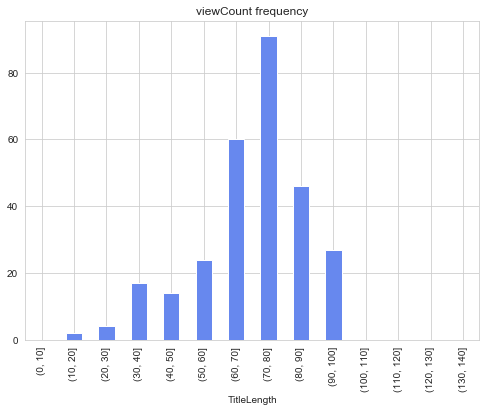

In [14]:
plot_top_length_performers(title_length, True)

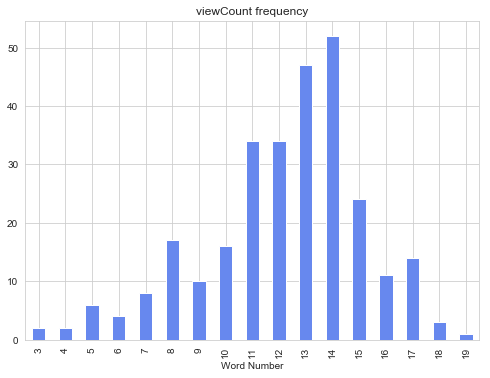

In [15]:
word_number = 'Word Number'
df_najwa[word_number] = df_najwa['videoTitle'].str.split().apply(len)
plot_top_length_performers(word_number, False)

In [16]:
def plot_top_performers(lst_col):
    for el in columns:
        column = df_najwa[el['column_name']]
        class_name = el['column_name']
        
        if class_name != title_length:
            plt.figure(figsize=(10,5))
            title_top = remove_outliers(df_najwa, class_name)
            title_top = title_top.sort_values(by=[class_name], ascending=False).head(int(len(title_top)*(PERCENTAGE/100.00)))
            x = pd.DataFrame({
                col:np.repeat(title_top[col].values, title_top[lst_col].str.len()) for col in title_top.columns.difference([lst_col])
            }).assign(**{lst_col:np.concatenate(title_top[lst_col].values)})[title_top.columns.tolist()]
            
            temp = x.groupby(lst_col).count()[class_name].sort_values(ascending=False).head(20).sort_values(ascending=True)
            temp.plot.barh()
            plt.title('Most used {} on top {}% {}'.format(lst_col, PERCENTAGE, el['column_text']));

In [17]:
df_najwa['videoTitle'] = df_najwa['videoTitle'].str.replace('\d', '')

In [18]:
df_najwa['videoTitle'] = df_najwa['videoTitle'].str.replace('Part','')

In [19]:
temp = df_najwa['videoTitle'].str.lower().str.replace('\W', ' ').str.split()
temp.head()

0    [transaksi, rekonsiliasi, oposisi, dapat, kurs...
1    [transaksi, rekonsiliasi, parpol, lompat, paga...
2    [transaksi, rekonsiliasi, dulu, begini, sekara...
3    [transaksi, rekonsiliasi, rekonsiliasi, bagi, ...
4    [transaksi, rekonsiliasi, pengamat, rekonsilia...
Name: videoTitle, dtype: object

In [20]:
df_najwa.iloc[2,1]

'Transaksi Rekonsiliasi: Dulu Begini Sekarang Begitu ( ) | Mata Najwa'

In [21]:
import nltk
from nltk.corpus import stopwords

stop = set(stopwords.words('indonesian'))
df_najwa['Words'] = temp.apply(lambda x: [item for item in x if item not in stop and not '\\' in item])
df_najwa.head()

,channelTitle,videoTitle,viewCount,TitleLength,Word Number,Words
0,Najwa Shihab,"Transaksi Rekonsiliasi: Oposisi Dapat Kursi, S...",117990,85,13,"[transaksi, rekonsiliasi, oposisi, kursi, setu..."
1,Najwa Shihab,Transaksi Rekonsiliasi: Parpol Lompat Pagar ( ...,195197,65,10,"[transaksi, rekonsiliasi, parpol, lompat, paga..."
2,Najwa Shihab,Transaksi Rekonsiliasi: Dulu Begini Sekarang B...,371174,73,11,"[transaksi, rekonsiliasi, mata, najwa]"
3,Najwa Shihab,"Transaksi Rekonsiliasi: Rekonsiliasi, Bagi-Bag...",217537,76,10,"[transaksi, rekonsiliasi, rekonsiliasi, kursi,..."
4,Najwa Shihab,Transaksi Rekonsiliasi - Pengamat: Rekonsilias...,280581,85,12,"[transaksi, rekonsiliasi, pengamat, rekonsilia..."


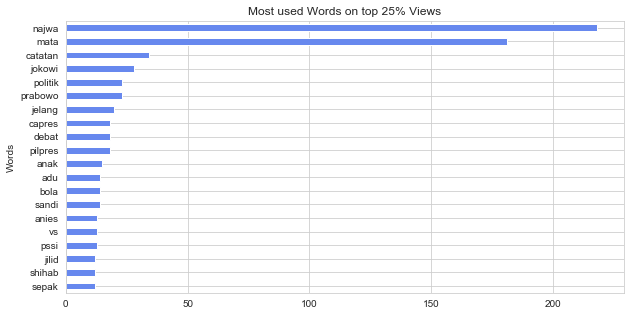

In [22]:
plot_top_performers('Words')

In [23]:
def get_category_name(column_name):
    return '{} Category'.format(column_name)

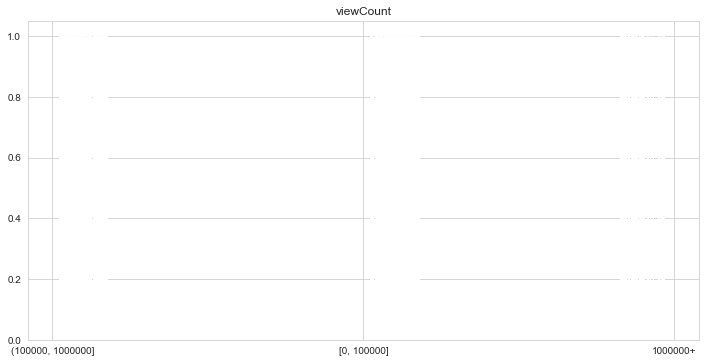

In [24]:
def get_range(value, ranges):
    for idx,max_value in enumerate(ranges):
        if value <= max_value:
            previous = '({}'.format(ranges[idx-1]) if idx >= 1 else '[0'
            return '{}, {}]'.format(previous, max_value)
    return '{}+'.format(ranges[-1])

# plot histogram of columns
plt.figure(figsize=(10, 5))
for el in columns:
    class_name = el['column_name']
    if class_name != title_length:
        column = df_najwa[class_name]
        plt.subplot(1, 1, columns.index(el) + 1)
        plt.tight_layout()
        ranges = {
            'viewCount': [100000, 1000000]
        }
        column = [ get_range(a, ranges[class_name]) for a in column ]
        plt.title('{}'.format(class_name))
        pd.DataFrame(column)[0].hist(xrot=0)
        
        # add classification to dataframe
        df_najwa[get_category_name(class_name)] = column

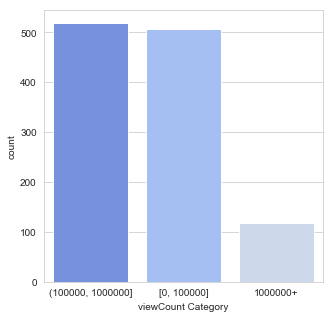

In [25]:
plt.figure(figsize=(5,5))
ax = sns.countplot(x = 'viewCount Category', data=df_najwa, order=df_najwa['viewCount Category'].value_counts().index)

In [26]:
df_najwa['viewCount Category'].unique().tolist()

['(100000, 1000000]', '[0, 100000]', '1000000+']

In [27]:
from sklearn.model_selection import train_test_split
import re

In [28]:
# clean the title
def clean_title(text):
    # remove twitter users, leave @ for stats reason
    text = text.map(lambda x: re.sub('@[_A-Za-z0-9]+','@',str(x)))
    return text


def split_data(df_najwa, class_name, is_remove_outlier, is_clean_text):
            # remove outliers
            if is_remove_outlier:
                title_stat_top = remove_outliers(df_najwa, class_name)
            else:
                title_stat_top = df_najwa
                
            # Set the number of testing points
            if is_clean_text:
                X_all = clean_title(title_stat_top['videoTitle'])
            else:
                X_all = title_stat_top['videoTitle']
            y_all = title_stat_top[get_category_name(class_name)]

            # Shuffle and split the dataset into the number of training and testing points above
            X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=ratios[class_name], shuffle=False)
        
            return {
                'title_stat_top': title_stat_top,
                'X_all': X_all,
                'y_all': y_all,
                'X_train': X_train,
                'X_test': X_test,
                'y_train': y_train,
                'y_test': y_test
            }

In [29]:
X_all = {}
y_all = {}
X_train = {}
X_test = {}
y_train = {}
y_test = {}

ratios = {
    'viewCount': 0.2
}

for el in columns:
    column = df_najwa[el['column_name']]
    class_name = el['column_name']
    if class_name != title_length:
        values = split_data(df_najwa, class_name, True, True)
        title_stat_top, X_all[class_name], y_all[class_name], X_train[class_name], X_test[class_name], y_train[class_name], y_test[class_name] = [values[k] for k in ('title_stat_top', 'X_all','y_all', 'X_train', 'X_test', 'y_train', 'y_test')]
        
        total = df_najwa[class_name].count()
        total_no_outliers = title_stat_top[class_name].count()
        print('{}\nTotal: {} items.\nTotal without outliers: {}'.format(class_name, total, total_no_outliers))
        
        # Show the results of the split
        print("Training set has {} samples".format(X_train[class_name].shape[0]))
        print("Testing set has {} samples\n".format(X_test[class_name].shape[0]))

viewCount
Total: 1142 items.
Total without outliers: 1013
Training set has 810 samples
Testing set has 203 samples



In [30]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.svm import LinearSVC, SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [31]:
import nltk
from nltk.corpus import stopwords
stop = set(stopwords.words('indonesian'))

In [32]:
X_train_word_features = {}
test_features = {}

In [33]:
def get_text_length(x):
    return np.array([len(t) for t in x]).reshape(-1, 1)

def get_words_length(x):
    return np.array([len(t.split()) for t in x]).reshape(-1, 1)

def to_array(x):
    return x.toarray()

In [34]:
classifiers = [
    {
        'classifier': GaussianNB(),
        'toarray': True,
        'parameters': {}
    },
    {
        'classifier': LogisticRegression(),
        'toarray': False,
        'parameters': {
            'C': [0.1, 0.5, 1, 2, 10],
            'fit_intercept': [True, False],
            'class_weight': ['balanced', None],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga'],
            'max_iter': [10, 100, 300]
        }
    },
    {
        'classifier': DecisionTreeClassifier(),
        'toarray': False,
        'parameters': {
            'splitter': ['random', 'best'],
            'max_depth': [1, 5, 10, 20, None],
            'class_weight': ['balanced', None]
        }
    },
    {
        'classifier': SVC(),
        'toarray': True,
        'parameters': {
            'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
            'degree':[1, 2, 3, 4, 5, 6, 7],
            'C':[0.5, 1, 2],
        }
    },
    {
        'classifier': KNeighborsClassifier(),
        'toarray': False,
        'parameters': {
            'n_neighbors': [1, 5, 10, 15, 20, 30], 
            'weights': ['distance', 'uniform'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'leaf_size': [10, 30, 50],
        }
    },
    {
        'classifier': MultinomialNB(),
        'toarray': False,
        'parameters': {
                'alpha': [0, 0.5, 1],
                'fit_prior': [True, False]
        }
    },
    {
        'classifier': GradientBoostingClassifier(),
        'toarray': False,
        'parameters': {
            'learning_rate': [0.1, 0.5, 1.0],
            'loss': ['deviance'],
            'max_depth': [3, 5, 10],
            'max_features': [None],
            'min_samples_leaf': [1, 2],
            'min_samples_split': [0.1, 0.5, 1.0],
            'min_weight_fraction_leaf': [0.0],
            'n_estimators': [50, 100],
            'random_state': [0, None],
            'subsample': [1.0],
            'warm_start': [False]
        }
    }
]

In [35]:
def get_score_pipeline(classifier_algo, X_train, y_train):
    classifier = Pipeline([
        ('features', FeatureUnion([
            ('text', Pipeline([
                ('vectorizer', TfidfVectorizer(
                                    stop_words=stop,
                                    strip_accents='unicode',
                                    token_pattern=r'\w{1,}',
                                    analyzer='word',
                                    ngram_range=(1,1),
                )),
                ('toarray', Pipeline([
                    ('count', FunctionTransformer(to_array, validate=False)),
                ]))
            ])),
            ('length', Pipeline([
                ('count', FunctionTransformer(get_text_length, validate=False)),
            ])),
            ('size', Pipeline([
                ('count', FunctionTransformer(get_words_length, validate=False))
            ]))
        ])),
        ('clf', OneVsRestClassifier(classifier_algo))])
    
    cv_score = np.mean(cross_val_score(classifier, X_train, y_train, cv=5, scoring='accuracy'))
    print('\t\tAccuracy Score: {}'.format(cv_score))
    return cv_score

In [36]:
def get_score(classifier_algo, X_train, X_test, y_train, y_test, name, is_td_idf=True, is_stop_word=True):
    tokens = tokenize(X_train, X_test, is_td_idf, is_stop_word)
    _X_train = tokens['X_train']
    _X_test = tokens['X_test']

    # fit model
    classifier_algo.fit(_X_train, y_train)
    # predict
    y_pred = classifier_algo.predict(_X_test)
    # measure
    cv_score = accuracy_score(y_test, y_pred)
    print('\t\tAccuracy score ({}): {}'.format(name, cv_score))
    return cv_score

In [37]:
def set_statistic_score(class_name, cv_score, model_name, accuracy, classifier_name):
    if class_name not in accuracy or accuracy[class_name] < cv_score:
        accuracy[class_name] = cv_score
        classifier_name[class_name] = model_name

In [38]:
def print_complete_stat(X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(X_test, y_test))

In [39]:
def tokenize(X_train, X_test, is_td_idf=True, is_stop_word=True):
    #TfidfVectorizer#CountVectorizer
    if is_td_idf:
        tokenizr = TfidfVectorizer
    else:
        tokenizr = CountVectorizer
    
    if is_stop_word:
        stop_words=stop
    else:
        stop_words=None
        
    word_vectorizer = tokenizr(
                        stop_words=stop_words,
                        strip_accents='unicode',
                        token_pattern=r'\w{1,}',
                        analyzer='word',
                        ngram_range=(1, 1))

    word_vectorizer.fit(X_train)
    _X_train = word_vectorizer.transform(X_train)
    _X_train = np.append(_X_train.todense(), get_text_length(X_train), 1)
    _X_train = np.append(_X_train, get_words_length(X_train), 1)
    _X_test = word_vectorizer.transform(X_test)
    _X_test = np.append(_X_test.todense(), get_text_length(X_test), 1)
    _X_test = np.append(_X_test, get_words_length(X_test), 1)
    return {
        'X_train': _X_train,
        'X_test': _X_test
    }

In [40]:
def set_score_stat(classifier_algo, class_name, X_train, X_test, y_train, y_test, accuracy, classifier_name, is_default):
    name_type = 'default' if is_default else 'optimized'
    name = '{} ({})'.format(classifier_algo.__class__.__name__, name_type)
    # cv_score = get_score_pipeline(classifier_algo, X_all[class_name], y_all[class_name])
    cv_score = get_score(classifier_algo, X_train, X_test, y_train, y_test, name_type)
    # store value, if better than others
    set_statistic_score(class_name, cv_score, name, accuracy, classifier_name)

In [41]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [42]:
classifier_name = {}
accuracy = {}

print('Default classifiers')

for clf in classifiers:
    print('Classifier: {}'.format(clf['classifier'].__class__.__name__))
    for el in columns:
        column = df_najwa[el['column_name']]
        class_name = el['column_name']
        if class_name != title_length:
            name='classifier-{}'.format(class_name)
            classifier_algo = clf[name] if name in clf else clf['classifier']
            print('\t{}'.format(class_name))
            
            set_score_stat(classifier_algo, class_name, X_train[class_name], X_test[class_name], y_train[class_name], y_test[class_name], accuracy, classifier_name, True)
            
print('Best scores: ')
print(accuracy)
print(classifier_name)

Default classifiers
Classifier: GaussianNB
	viewCount
		Accuracy score (default): 0.571428571429
Classifier: LogisticRegression
	viewCount
		Accuracy score (default): 0.689655172414
Classifier: DecisionTreeClassifier
	viewCount


/Users/anggapradiktas/anaconda3/envs/py36/lib/python2.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens [u'baiknya', u'berkali', u'kali', u'kurangnya', u'mata', u'olah', u'sekurang', u'setidak', u'tama', u'tidaknya'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/anggapradiktas/anaconda3/envs/py36/lib/python2.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens [u'baiknya', u'berkali', u'kali', u'kurangnya', u'mata', u'olah', u'sekurang', u'setidak', u'tama', u'tidaknya'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/anggapradiktas/anaconda3/envs/py36/lib/python2.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the sto

		Accuracy score (default): 0.571428571429
Classifier: SVC
	viewCount


/Users/anggapradiktas/anaconda3/envs/py36/lib/python2.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens [u'baiknya', u'berkali', u'kali', u'kurangnya', u'mata', u'olah', u'sekurang', u'setidak', u'tama', u'tidaknya'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


		Accuracy score (default): 0.64039408867
Classifier: KNeighborsClassifier
	viewCount
		Accuracy score (default): 0.64039408867
Classifier: MultinomialNB
	viewCount
		Accuracy score (default): 0.428571428571
Classifier: GradientBoostingClassifier
	viewCount


/Users/anggapradiktas/anaconda3/envs/py36/lib/python2.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens [u'baiknya', u'berkali', u'kali', u'kurangnya', u'mata', u'olah', u'sekurang', u'setidak', u'tama', u'tidaknya'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/anggapradiktas/anaconda3/envs/py36/lib/python2.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens [u'baiknya', u'berkali', u'kali', u'kurangnya', u'mata', u'olah', u'sekurang', u'setidak', u'tama', u'tidaknya'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/anggapradiktas/anaconda3/envs/py36/lib/python2.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the sto

		Accuracy score (default): 0.610837438424
Best scores: 
{'viewCount': 0.6896551724137931}
{'viewCount': 'LogisticRegression (default)'}


In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from scipy.sparse import hstack

In [44]:
accuracy = {}
classifier_name = {}
import warnings; warnings.simplefilter('ignore')

In [45]:
for classifier in classifiers:
    for el in columns:
        column = df_najwa[el['column_name']]
        class_name = el['column_name']
        clf = classifier['classifier']
        parameters = classifier['parameters']
        print('Classifier: {}'.format(clf.__class__.__name__))
        if class_name != title_length:
            print('\t=={}=='.format(class_name))
            
            set_score_stat(classifier_algo, class_name, X_train[class_name], X_test[class_name], 
                           y_train[class_name], y_test[class_name].values, accuracy, classifier_name, True)
            
            grid_obj = GridSearchCV(clf, param_grid=parameters, scoring=make_scorer(accuracy_score))
            tokens = tokenize(X_train[class_name], X_test[class_name])
            _X_train = tokens['X_train']
            
            grid_obj = grid_obj.fit(_X_train, y_train[class_name])
            
            print('Model Best Estimator: {}'.format(grid_obj.best_estimator_))
            
            #models_winners[class_name] = grid_obj.best_estimator_
            
            classifier_algo = grid_obj.best_estimator_
            
            set_score_stat(classifier_algo, class_name, X_train[class_name], X_test[class_name],
                          y_train[class_name], y_test[class_name].values, accuracy, classifier_name, False)

Classifier: GaussianNB
	==viewCount==
		Accuracy score (default): 0.610837438424
Model Best Estimator: GaussianNB(priors=None, var_smoothing=1e-09)
		Accuracy score (optimized): 0.571428571429
Classifier: GaussianNB
Classifier: LogisticRegression
	==viewCount==
		Accuracy score (default): 0.571428571429
Model Best Estimator: LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)
		Accuracy score (optimized): 0.704433497537
Classifier: LogisticRegression
Classifier: DecisionTreeClassifier
	==viewCount==
		Accuracy score (default): 0.704433497537
Model Best Estimator: DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_sam

In [46]:
models_winners = {
    'viewCount': LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)
}

info = {}
for el in columns:
    column = df_najwa[el['column_name']]
    class_name = el['column_name']
    acc = []
    if class_name != title_length:
        print('\t={}='.format(class_name))
        
        configurations = [
            {'is_remove_outlier':False, 'is_clean_text':False, 'is_td_idf':False, 'is_stop_word': False, 'title':'Benchmark',
             'tag':'benchmark', 'model_winner':False},
            {'is_remove_outlier': True, 'is_clean_text': False, 'is_td_idf': False, 'is_stop_word':  False, 'title': 'No outlier', 'tag': 't1', 'model_winner': False},
            {'is_remove_outlier': True, 'is_clean_text': True, 'is_td_idf': False, 'is_stop_word':  False, 'title': 'No outlier + clean words', 'tag': 't2', 'model_winner': False},
            {'is_remove_outlier': True, 'is_clean_text': True, 'is_td_idf': True, 'is_stop_word':  False, 'title': 'No outlier + clean words + td-idf', 'tag': 't3', 'model_winner': False},
            {'is_remove_outlier': True, 'is_clean_text': True, 'is_td_idf': True, 'is_stop_word':  True, 'title': 'No outlier + clean words + td-idf + stopwords', 'tag': 't4', 'model_winner': False},
            {'is_remove_outlier': True, 'is_clean_text': True, 'is_td_idf': True, 'is_stop_word':  True, 'title': 'Winner model = No outliers + clean words + td-idf + stopwords + parameter tuned', 'tag': 'winner', 'model_winner': True},
        ]
        
        for c in configurations:
            print(c['title'])
            classifier_algo=models_winners[class_name] if c['model_winner'] else LogisticRegression()
            values = split_data(df_najwa, class_name, c['is_remove_outlier'], c['is_clean_text'])
            
            title_stat_top2, X2_all, y2_all, X2_train, X2_test, y2_train, y2_test = [values[k] for k in ('title_stat_top', 'X_all','y_all', 'X_train', 'X_test', 'y_train', 'y_test')]
            acc.append(get_score(classifier_algo, X2_train, X2_test, y2_train, y2_test, c['tag'], c['is_td_idf'], c['is_stop_word']))

        info[class_name] = pd.DataFrame({
            'evolution': ['benchmark', 't1', 't2', 't3', 't4', 'winner'], 
            'accuracy': list(map(lambda x: 100*x, acc))
        })

	=viewCount=
Benchmark
		Accuracy score (benchmark): 0.620087336245
No outlier
		Accuracy score (t1): 0.64039408867
No outlier + clean words
		Accuracy score (t2): 0.64039408867
No outlier + clean words + td-idf
		Accuracy score (t3): 0.679802955665
No outlier + clean words + td-idf + stopwords
		Accuracy score (t4): 0.689655172414
Winner model = No outliers + clean words + td-idf + stopwords + parameter tuned
		Accuracy score (winner): 0.704433497537


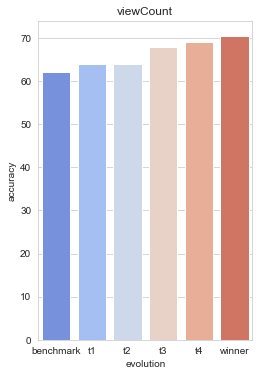

In [47]:
plt.figure(figsize=(10, 5))
for el in columns:
    class_name = el['column_name']
    if class_name != title_length:
        plt.subplot(1, 3, columns.index(el) + 1)
        plt.tight_layout()
        plt.title(class_name);
        values = info[class_name]
        sns.barplot(values['evolution'], values['accuracy'])
        #sns.despine()

<b>
Benchmark
<br>
t1: Removed outliers
<br>
t2: t1 + Cleaned the words
<br>
t3: t2 + Added TF-IDF
<br>
t4: t3 + Used stopwords
<br>
Winner: t4 + Parameters from the model tuned
</b>

In [48]:
# from sklearn.externals import joblib 
# joblib.dump(grid_obj.best_estimator_, 'grid_obj.pkl') 

In [49]:
# joblib.dump(grid_obj.best_params_, 'grid_obj_best_params.pkl')

In [50]:
#df_najwa['videoTitle'] = df_najwa['videoTitle'].map(lambda x: re.sub(r'\W+', ' ', x)).str.lower()

In [51]:
#df_najwa.to_csv('df_najwa.csv')

In [52]:
# import pickle
# pickle.dump(grid_obj.best_params_, open('final_prediction.pickle', 'wb'))

In [53]:
# df_najwa['viewCount Category']